In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Generating techer outputs

In [ ]:
base_dir = '/content/drive/My Drive/Projects/Fiverr/knowledge distillation/data'

In [ ]:
!git clone https://github.com/alexanderkroner/saliency.git

Cloning into 'saliency'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 88 (delta 14), reused 12 (delta 5), pack-reused 58
Unpacking objects: 100% (88/88), done.


In [ ]:
zip_file = base_dir+'/salicon.tar.gz'
!cp '{zip_file}' .
!tar -xzf salicon.tar.gz
!rm salicon.tar.gz

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!rm -rf ./data/salicon/tsaliency

In [ ]:
!python ./saliency/main.py test -p ./data/salicon/stimuli/val



>> Start testing with SALICON gpu model...


In [ ]:
import os, pickle

for f in os.listdir('./saliency/results/images/'):
    with open('./saliency/results/images/'+f, 'rb') as f:
        a = pickle.load(f)
    break

a.shape

(240, 320, 1)

In [ ]:
!tar -czf salicon2.tar.gz data
!cp salicon2.tar.gz '{base_dir}'

In [ ]:
!rm salicon2.tar.gz

#### Moving Files 

In [ ]:
base_dir = '/content/drive/My Drive/Projects/Fiverr/knowledge distillation/'

In [ ]:
zip_file = base_dir+'data/salicon2.tar.gz'
!cp '{zip_file}' .
!tar -xzf salicon2.tar.gz
!rm salicon2.tar.gz

#### Model

In [ ]:
import tensorflow as tf

class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block

def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block

class ResNet(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNet, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        output = self.layer4(x, training=training)

        return output

def resnet_18():
    return ResNet(layer_params=[2, 2, 2, 2])

def resnet_34():
    return ResNet(layer_params=[3, 4, 6, 3])  


def _decoder(features, smoothing_factor=1.0, simple_model=True):

    layer1 = tf.keras.layers.UpSampling2D(size=(2,2),
                                          interpolation='bilinear')(features)

    layer2 = tf.keras.layers.Conv2D(256, 3,
                                    padding="same",
                                    activation=tf.nn.relu,
                                    name="decoder/conv1")(layer1)


    layer3 = tf.keras.layers.UpSampling2D(size=(2,2),
                                          interpolation='bilinear')(layer2)

    layer4 = tf.keras.layers.Conv2D(128, 3,
                                    padding="same",
                                    activation=tf.nn.relu,
                                    name="decoder/conv2")(layer3)

    shape = tf.keras.backend.int_shape(layer4)

    layer5 = tf.keras.layers.UpSampling2D(size=(2,2),
                                          interpolation='bilinear')(layer4)

    layer6 = tf.keras.layers.Conv2D(64, 3,
                                    padding="same",
                                    activation=tf.nn.relu,
                                    name="decoder/conv3")(layer5)
    
    layer7 = tf.keras.layers.UpSampling2D(size=(2,2),
                                          interpolation='bilinear')(layer6)

    layer8 = tf.keras.layers.Conv2D(32, 3,
                                    padding="same",
                                    activation=tf.nn.relu,
                                    name="decoder/conv4")(layer7)

    layer9 = tf.keras.layers.UpSampling2D(size=(2,2),
                                          interpolation='bilinear')(layer8)

    layer10 = tf.keras.layers.Conv2D(16, 3,
                                    padding="same",
                                    activation=tf.nn.relu,
                                    name="decoder/conv5")(layer9) 

    decoder_output1 = tf.keras.layers.Conv2D(1, 3,
                                    padding="same",
                                    activation='sigmoid',
                                    name="decoder/conv6_1")(layer9)

    decoder_output2 = tf.keras.layers.Conv2D(1, 3,
                                            padding="same",
                                            activation='sigmoid',
                                            name="decoder/conv6_2")(layer10)
    decoder_output2 = decoder_output2/smoothing_factor

    if (simple_model):
        decoder_output = decoder_output1
    else:
        decoder_output = tf.keras.layers.Concatenate(axis=-1)([decoder_output1, decoder_output2])
    
    return decoder_output

def _base_model(input_shape, smoothing_factor=1.0, simple_model=True):
    input = tf.keras.layers.Input(shape=input_shape)
    
    encoder = resnet_18()
    encoder.build(tuple([None]) + input_shape)

    encoding = encoder(input)
    output = _decoder(encoding, smoothing_factor, simple_model)

    model = tf.keras.models.Model(input, output)

    return model

#### Loss

In [ ]:
@tf.function
def kld(y_true, y_pred, eps=1e-7):
    sum_per_image = tf.reduce_sum(y_true, axis=(1, 2, 3), keepdims=True)
    y_true /= eps + sum_per_image

    sum_per_image = tf.reduce_sum(y_pred, axis=(1, 2, 3), keepdims=True)
    y_pred /= eps + sum_per_image

    loss = y_true * tf.math.log(eps + y_true / (eps + y_pred))
    loss = tf.reduce_mean(tf.reduce_sum(loss, axis=(1, 2, 3)))

    return loss
    
def multi_loss(smoothing_factor):
    def loss(y_true, y_pred):
        saliency, t_saliency = y_true[:, :, :, 0:1], y_true[:, :, :, 1:]
        pred_saliency, pred_t_saliency = y_pred[:, :, :, 0:1], y_pred[:, :, :, 1:]

        kl_loss = kld(saliency, pred_saliency)
        t_kl_loss = kld(t_saliency/3, pred_t_saliency) 

        return kl_loss + 2.5*t_kl_loss

    return loss

def base_kld(y_true, y_pred):
    saliency= y_true[:, :, :, 0:1]
    return kld(saliency, y_pred)

#### KL-Divergence Metric

In [ ]:
class kl_divergennce(tf.keras.metrics.Metric):

  def __init__(self, name='kld', **kwargs):
    super(kl_divergennce, self).__init__(name=name, **kwargs)
    self.kld = self.add_weight(name='kld', initializer='zeros')
    self.total = self.add_weight('total', initializer='zeros')
    self.count = self.add_weight('count', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    saliency= y_true[:, :, :, 0:1]
    y_pred= y_pred[:, :, :, 0:1]

    kl_loss = kld(saliency, y_pred)
    self.total.assign_add(kl_loss)
    self.count.assign_add(1)

    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)

    self.kld.assign(tf.divide(self.total, self.count))

  def result(self):
    return self.kld

  def reset_states(self):
    self.kld.assign(0)
    self.count.assign(0)
    self.total.assign(0)


#### Compiling model

In [ ]:
base_model = _base_model(input_shape=(256, 352, 3))
base_model_kd = _base_model(input_shape=(256, 352, 3), smoothing_factor=3, simple_model=False)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=(0.0005))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

base_model.compile(optimizer=optimizer, 
                  loss=base_kld,
                  metrics=kl_divergennce())

base_model_kd.compile(optimizer=optimizer, 
                  loss=multi_loss(smoothing_factor=3),
                  metrics=kl_divergennce())

In [ ]:
base_model.summary()
base_model_kd.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 352, 3)]     0         
_________________________________________________________________
res_net_4 (ResNet)           (None, 8, 11, 512)        11190912  
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 16, 22, 512)       0         
_________________________________________________________________
decoder/conv1 (Conv2D)       (None, 16, 22, 256)       1179904   
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 32, 44, 256)       0         
_________________________________________________________________
decoder/conv2 (Conv2D)       (None, 32, 44, 128)       295040    
_________________________________________________________________
up_sampling2d_22 (UpSampling (None, 64, 88, 128)      

#### Data Generator

In [ ]:
from imgaug import augmenters as iaa

augmenter = iaa.Sequential(
    [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5)    
    ],
    random_order=True,
)

In [ ]:
import random
import pickle
import numpy as np
import os
import cv2
from skimage.transform import resize

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, base_path, target_size=(224, 224), type_='train', batch_size=32, random_state=0, augmenter=None):
        
        self.stimuli_path = os.path.join(base_path, f'stimuli/{type_}')
        self.saliency_path = os.path.join(base_path, f'saliency/{type_}')
        self.tsaliency_path = os.path.join(base_path, f'tsaliency/{type_}')
        self.augmenter=augmenter
        self.batch_size = batch_size
        self.target_size = target_size
        self.random_state = random_state
        
        self._get_files(self.stimuli_path)

        self.steps = int(len(self.files)/batch_size)
        print(f'{self.steps} batches')

    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]

        imagenet_mean = [103.939, 116.779, 123.68]
        stimuli = [(cv2.imread(os.path.join(self.stimuli_path, path+'.jpg')) - imagenet_mean)/255.0
                   for path in batch_files]

        stimuli = np.array([resize(img, self.target_size) for img in stimuli])

        tsaliency = []
        for path in batch_files:
            with open(os.path.join(self.tsaliency_path, path+'.pkl'), 'rb') as fp:
                tsaliency.append(resize(pickle.load(fp), self.target_size))
        
        saliency = np.asarray([resize(cv2.imread(os.path.join(self.saliency_path, path+'.png'), 0), self.target_size) 
                                for path in batch_files])

        if(self.augmenter):
            aug = self.augmenter.to_deterministic()
            
            stimuli = np.array(aug.augment_images(stimuli))
            saliency = np.array(aug.augment_images(saliency))
            tsaliency = np.array(aug.augment_images(tsaliency))

        y = np.concatenate((np.expand_dims(saliency, -1), tsaliency), axis=-1)
        x = stimuli

        return x, y

    def _get_files(self, base_path):
        self.files = []
        for f in os.listdir(base_path):
            self.files.append(os.path.splitext(f)[0])

    def on_epoch_end(self):
        self.random_state +=1
        random.seed(a=self.random_state)
        random.shuffle(self.files)

In [ ]:
train_gen = DataGenerator('./data/salicon', target_size=(256, 352), augmenter=augmenter)

312 batches


In [ ]:
val_gen = DataGenerator('./data/salicon', target_size=(256, 352), type_='val')

156 batches


#### Callbacks

In [ ]:
class Sample(tf.keras.callbacks.Callback):

    def __init__(self, val_gen, model, base_path='.'):
        super(Sample, self).__init__()
        self.val_gen = val_gen
        self.model = model
        self.base_path=base_path

    def on_epoch_end(self, epoch, logs={}):
        idx = np.random.randint(0, len(self.val_gen), None)
        x = self.val_gen[idx][0][0:1]
        y = self.val_gen[idx][1][0, :, :, 0:1]
        y_dash = self.model.predict(x)[0, :, :, 0:1]

        kld = logs['kld']
        loss = logs['loss']
        
        cv2.imwrite(os.path.join(self.base_path,f'salinecy {epoch}.png'), y_dash*255.0)
        cv2.imwrite(os.path.join(self.base_path,f'ground truth {epoch}.png'), y*255.0)
        cv2.imwrite(os.path.join(self.base_path,f'image {epoch}.png'), x[0]*255.0 + [103.939, 116.779, 123.68])

#### Training

##### Without knowledge distillation 

In [ ]:
!mkdir base_model

In [ ]:
history = base_model.fit(train_gen, validation_data = val_gen, epochs=10, 
                callbacks=[Sample(val_gen, base_model, './base_model'), 
                tf.keras.callbacks.ModelCheckpoint('./base_model/model.h5', 
                                                   save_weights_only=True, 
                                                   save_best_only=True)])

Epoch 1/10
312/312 [==============================] - 1153s 4s/step - loss: 1.2948 - kld: 1.2948 - val_loss: 1.2057 - val_kld: 1.2057
Epoch 2/10
312/312 [==============================] - 1147s 4s/step - loss: 1.2807 - kld: 1.2807 - val_loss: 1.2058 - val_kld: 1.2058
Epoch 3/10
312/312 [==============================] - 1124s 4s/step - loss: 1.2804 - kld: 1.2804 - val_loss: 1.2060 - val_kld: 1.2060
Epoch 4/10
312/312 [==============================] - 1109s 4s/step - loss: 1.2804 - kld: 1.2804 - val_loss: 1.2059 - val_kld: 1.2059
Epoch 5/10
312/312 [==============================] - 1113s 4s/step - loss: 1.2806 - kld: 1.2806 - val_loss: 1.2059 - val_kld: 1.2059
Epoch 6/10
312/312 [==============================] - 1114s 4s/step - loss: 1.2800 - kld: 1.2800 - val_loss: 1.2057 - val_kld: 1.2057
Epoch 7/10
312/312 [==============================] - 1104s 4s/step - loss: 1.2802 - kld: 1.2802 - val_loss: 1.2056 - val_kld: 1.2056
Epoch 8/10
312/312 [==============================] - 1109s 4s

In [ ]:
with open('./base_model/history.pkl', 'wb') as fp:
    pickle.dump({'history':history.history}, fp)

In [ ]:
!cp -r base_model /content/drive/My\ Drive/Projects/Fiverr/knowledge\ distillation/

##### With knowledge distillation 

In [ ]:
!mkdir knowledge_distilled_model

In [ ]:
history = base_model_kd.fit(train_gen, validation_data = val_gen, epochs=10, 
                callbacks=[Sample(val_gen, base_model_kd, './knowledge_distilled_model'), 
                tf.keras.callbacks.ModelCheckpoint('./knowledge_distilled_model/model.h5', 
                                                   save_weights_only=True, 
                                                   save_best_only=True)])

Epoch 1/10
312/312 [==============================] - 1133s 4s/step - loss: 1.6452 - kld: 0.6234 - val_loss: 1.3871 - val_kld: 0.5210
Epoch 2/10
312/312 [==============================] - 1145s 4s/step - loss: 1.1794 - kld: 0.4755 - val_loss: 1.0105 - val_kld: 0.4099
Epoch 3/10
312/312 [==============================] - 1137s 4s/step - loss: 1.0098 - kld: 0.4224 - val_loss: 0.9167 - val_kld: 0.3862
Epoch 4/10
312/312 [==============================] - 1112s 4s/step - loss: 0.9101 - kld: 0.3919 - val_loss: 0.8366 - val_kld: 0.3643
Epoch 5/10
312/312 [==============================] - 1108s 4s/step - loss: 0.8261 - kld: 0.3654 - val_loss: 0.8251 - val_kld: 0.3601
Epoch 6/10
312/312 [==============================] - 1108s 4s/step - loss: 0.7727 - kld: 0.3490 - val_loss: 0.7323 - val_kld: 0.3307
Epoch 7/10
312/312 [==============================] - 1101s 4s/step - loss: 0.7312 - kld: 0.3361 - val_loss: 0.7467 - val_kld: 0.3327
Epoch 8/10
312/312 [==============================] - 1106s 4s

In [ ]:
with open('./knowledge_distilled_model/history.pkl', 'wb') as fp:
    pickle.dump({'history':history.history}, fp)

In [ ]:
!cp -r knowledge_distilled_model /content/drive/My\ Drive/Projects/Fiverr/knowledge\ distillation/

#### Results vizulaization

###### Without knowledge distillation

In [ ]:
from matplotlib import pyplot as plt
import pickle

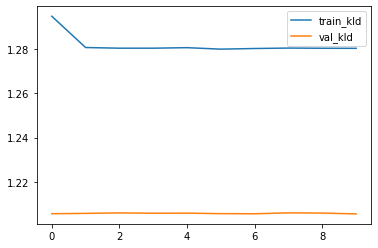

In [ ]:
with open('./base_model/history.pkl', 'rb') as fp:
    history_kd = pickle.load(fp)

plt.plot(history_kd['history']['kld']) 
plt.plot(history_kd['history']['val_kld']) 
plt.legend(['train_kld', 'val_kld'])
plt.show()

##### With knowledge distillation

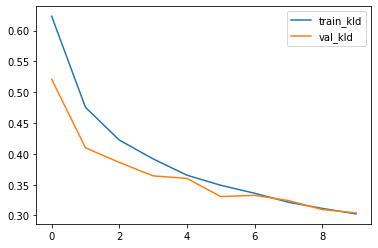

In [ ]:
with open('./knowledge_distilled_model/history.pkl', 'rb') as fp:
    history_kd = pickle.load(fp)

plt.plot(history_kd['history']['kld']) 
plt.plot(history_kd['history']['val_kld']) 
plt.legend(['train_kld', 'val_kld'])
plt.show()